# LAB: quasi-Newton methods

Author : Alexandre Gramfort, Jair Montoya, Pierre Ablin

The objective of this lab session is to implement:
- Newton method
- DFP
- BFGS
- L-BFGS

And to investigate their behaviors.

You will need to use **line search methods**.

## VERY IMPORTANT

- This work **must be done by pairs of students**.
- **Each** student must send their work as jupyter notebook one week after the lab on the **moodle platform**.
- This means that **each student in the pair sends the same file**.
- The **name of the file must be** constructed as in the next cell.

# Gentle reminder: no evaluation if you don't respect this EXACTLY

### How to construct the name of your file

In [1]:
# Change here using YOUR first and last names
fn1 = "Zakaria"
ln1 = "echchair"
fn2 = "Marouane"
ln2 = "najid"

filename = "_".join(map(lambda s: s.strip().lower(), 
                        ["tp_newton", ln1, fn1, "and", ln2, fn2])) + ".ipynb"
print(filename)

tp_newton_echchair_zakaria_and_najid_marouane.ipynb


# Part 0: Demo using Gradient descent

First import the necessary libraries:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

%matplotlib inline

Now import the necessary function from the optim_utils.py file.

In [3]:
from optim_utils import test_solver

You'll only need the `test_solver` function.

This function expects a function as parameter.

The signature of the function `optimizer` to pass should be the following:

`optimizer(x0, f, f_grad, f_hessian)`

First, an example with a gradient descent.

In [4]:
def gradient_descent(x0, f, f_grad, f_hessian=None):

    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = [], []
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              -grad_x, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        x -= step * grad_x

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)

Now, call the `test_solver` function with this solver:


Running solver on case 1

Running solver on case 2

Running solver on case 3


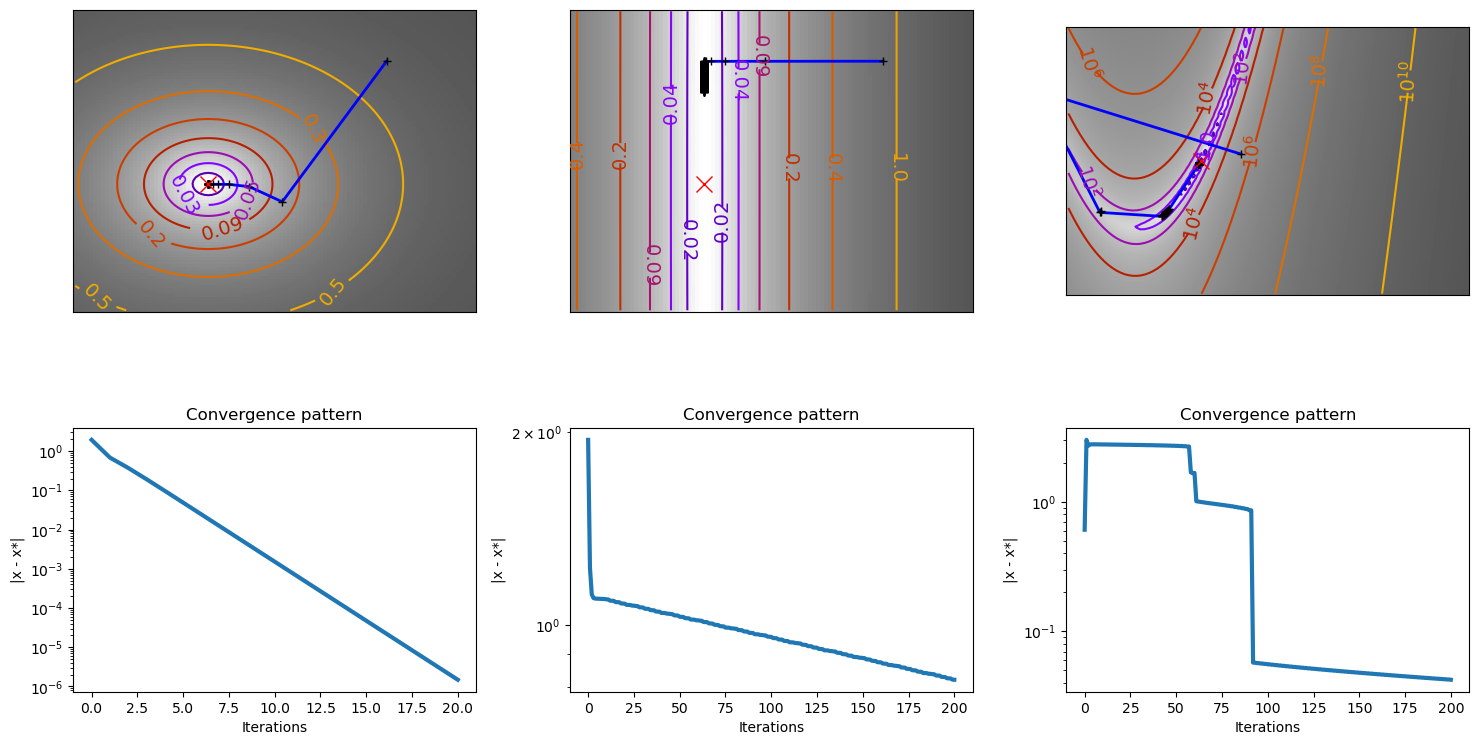

In [5]:
test_solver(gradient_descent)

It runs the algorithm on three functions:
- A non-convex Gaussian kernel ($f(x) = -\exp(-\|x\|^2)$)
- A badly conditioned quadratic function (but still strongly convex)
- The Rosenbrock function
    

# Part 1: Implement Newton method

<div class="alert alert-success">
    <b>QUESTION 1:</b>
     <ul>
         <li>Implement Newton's method. Beware that the Hessian SHOULD be regularized !</li>
         <li>Comment on what you observe. Do not describe the curves
             but rather comment if convergence rates match theoretical results.</li>
    </ul>
</div>

In [6]:
from scipy import linalg

def newton(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.00001
    c2 = 0.95
    max_iter = 100
    lambda_threshold = 0.0001 # regularization threshold
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    for k in range(1, max_iter + 1):

        grad_x = f_grad(x)
        
        # Compute the Hessian, regularize it and compute the search direction d
        
        # TODO 
        H = f_hessian(x)
        
        eig = np.linalg.eigvalsh(H)
        if (eig >= lambda_threshold).all() == False : 
            H += (lambda_threshold - min(eig)) * np.identity(H.shape[0])
        
        d = -linalg.solve(H, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute here the new value of x
        x += step * d

        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %(k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


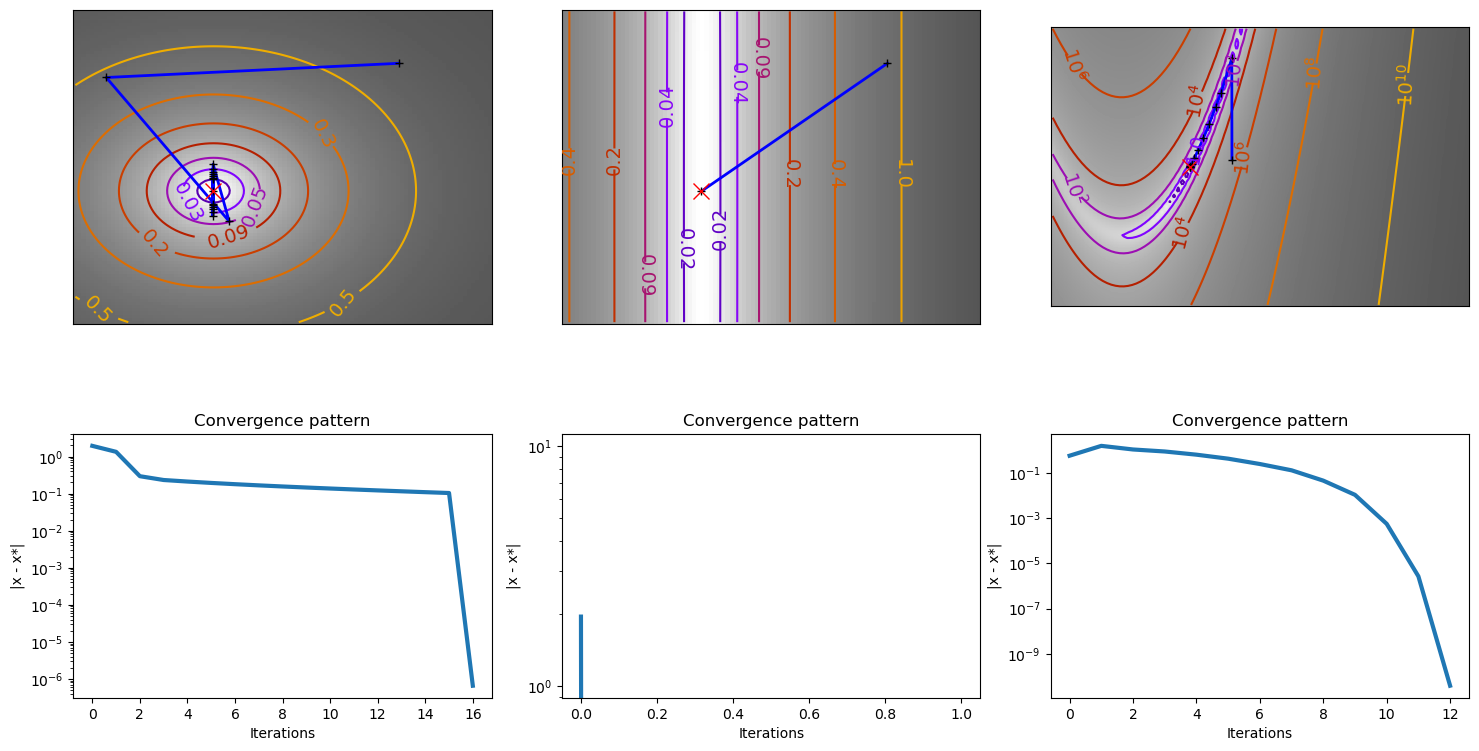

In [7]:
test_solver(newton)


<div class="alert alert-info">

- $1^{st}$ case: The Newton method is able to find a minimum of a Gaussian kernel in 16 iterations using Hessian regularization and a line-search-derived optimal step size.
- $2^{nd}$ case : The Newton approach converges in a single step for this example because the second function is quadratic and the Newton method always converges in one iteration regardless of the initial point $x_0$ and the conditioning of the function.
- $3^{rd}$ case : The Newton approach quickly finds a minimum of around $10^{-9}$ in 12 iterations, but gradient descent is still searching for the minimum after 200 iterations, despite the non-quadratic, non-convex, and poorly conditioned Rosenbrock function.


- This is because the gradient approach has a linear convergence while the Newton method has a quadratic one.
- Bad conditioning has no impact on the Newton technique.
    
</div>

# Part 2: Implement DFP algorithm

<div class="alert alert-success">
    <b>QUESTION 2:</b>
     <ul>
         <li>Now, implement the DFP algorithm using the formula for $B$ in the slides.</li>
         <li>Comment on what you observe. Focus on the explanation, not on describing the curves!</li>
         <li>Isn't there a contradiction on the quadratic functions with what we've seen in class? What is going on?</li>
    </ul>
</div>

In [8]:
def dfp(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.95
    max_iter = 200
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # inverse Hessian approximation, start from Id
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = np.dot(B, -grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
        
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x = x + s
        y = new_grad - grad_x
        ################################################################
        # Update the inverse Hessian approximation
    
        B += np.outer(s,s) / s.dot(y) - B.dot(np.outer(y,y).dot(B)) / y.dot(B.dot(y))       
        ################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


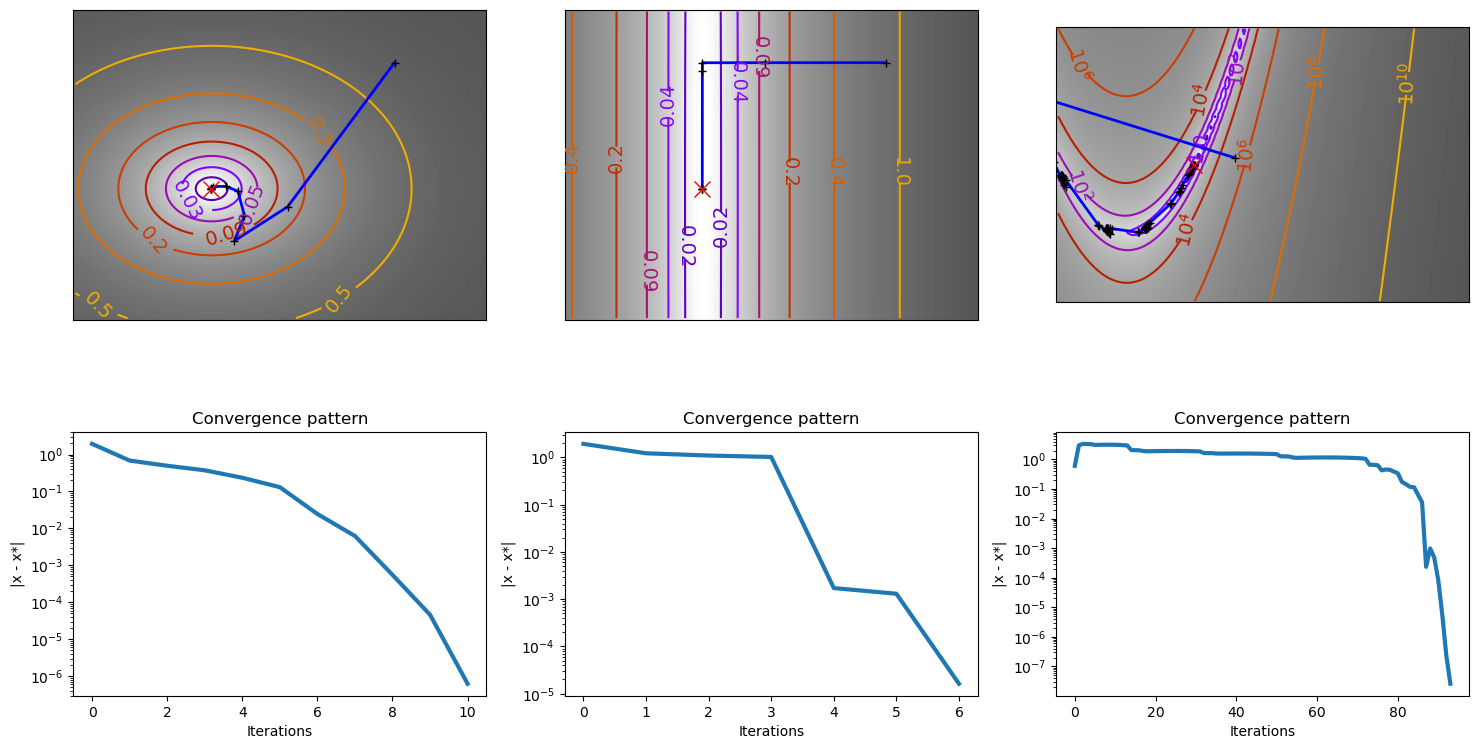

In [9]:
test_solver(dfp)


<div class="alert alert-info">

- The inverse of the hessian matrix receives a rank 2 update from the DFP algorithm, which also ensures that it stays positive semi-definite.


- $1^{st}$ case: The DFP algorithm has faster convergence than the Newton algorithm. This is because the DFP algorithm starts with a positive semi-definite inverse Hessian matrix and updates it in a way that maintains its positive semi-definiteness.
- $2^{nd}$ case : The DFP algorithm is theoretically supposed to converge in p+1 iterations when applied to quadratic functions, where p is the dimension of the input space. However, in the given example, the algorithm needed 6 iterations to converge when $p=2$, which suggests that the convergence is slower than what is theoretically expected. This is likely due to the fact that line search is only an approximate method for finding the optimal step size, and it may not always return the exact optimal step size.
- $3^{rd}$ case : Compared to the Newton technique, the DFP algorithm converges after more than 100 iterations, and we can see some bounds in the convergence curve.


- The global minimum of the Rosenbrock function is located in a long, narrow, flat valley with a parabolic shape. The Newton method is successful in finding this minimum because it uses the exact Hessian matrix to determine the optimal direction for minimization, whereas the DFP method uses an approximation of the inverse Hessian matrix which may not accurately capture the curvature of the Rosenbrock curve and therefore may not be as effective.
    
</div>


# Part 3: Implement BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 3:</b>
     <ul>
         <li>You should now implement BFGS, using the formula for $B_t$ seen in the slides.</li>
         <li>Comment on what you observe.</li>
    </ul>
</div>

In [10]:
def bfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = -np.dot(B, grad_x)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        ##################################################################
        # Update the inverse Hessian approximation
        V = np.eye(len(x)) - np.outer(y,s) / y.dot(s)
        B = V.T.dot(B.dot(V)) + np.outer(s,s) / y.dot(s)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


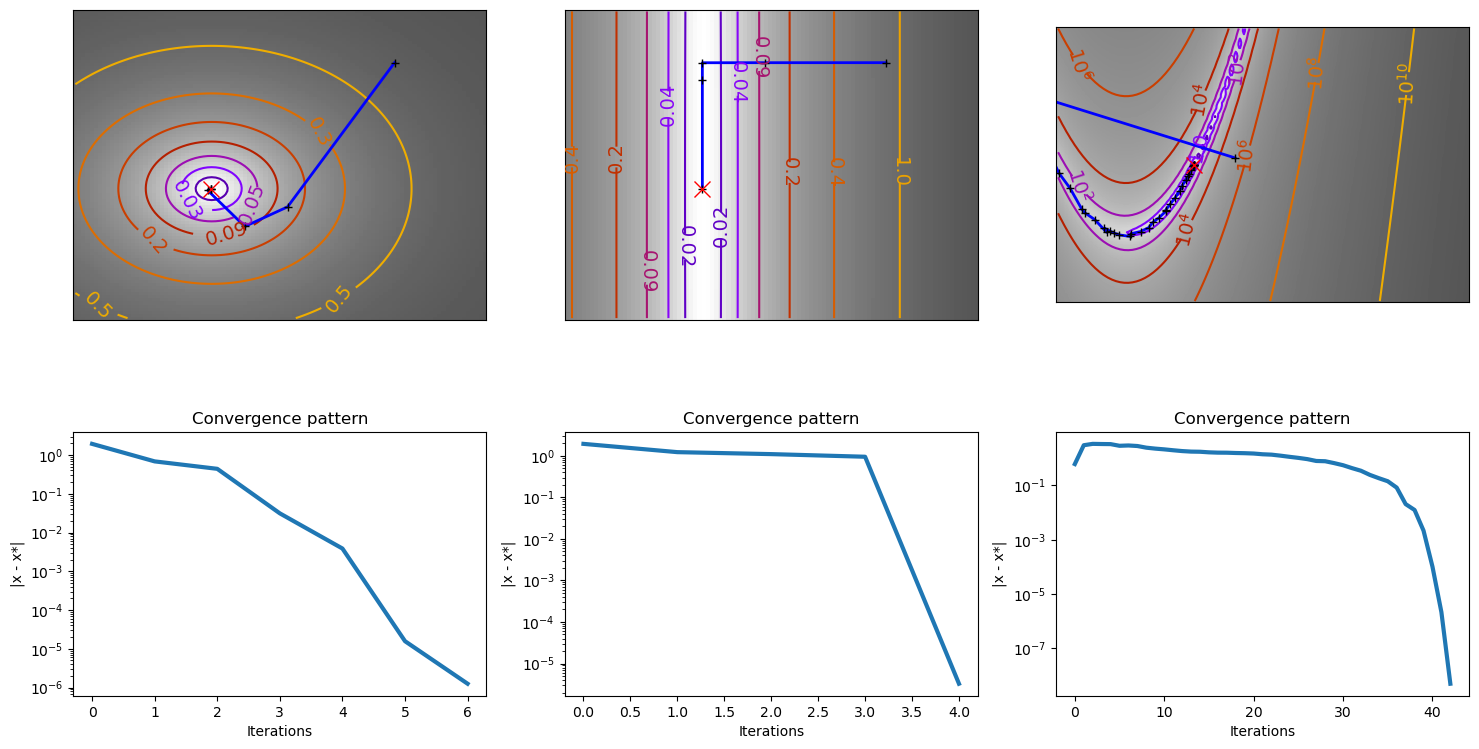

In [11]:
test_solver(bfgs)


<div class="alert alert-info">

- The convergence paths of BFGS and DFP are similar for the 3 functions, and they have similar behavior.
- BFGS is faster than DFP for the 3 cases, requiring fewer iterations to converge. It is also less sensitive to line-search inaccuracy. For example, for the quadratic function that should converge in p+1 iterations, BFGS converged in just 4 iterations, whereas DFP required more iterations to reach convergence.
    
</div>


# Part 4: Implement L-BFGS algorithm


<div class="alert alert-success">
    <b>QUESTION 4:</b>
     <ul>
         <li>You should now implement the L-BFGS algorithm. We ask you to code the two-loops recursion in the function called two_loops.</li>
         <li>Comment briefly on what you see.</li>
    </ul>
</div>

**Remark:** The question is hard. Consider this as a bonus question.

In [12]:
def two_loops(grad_x, m, s_list, y_list, mu_list, B0):
    '''
    Parameters
    ----------
    grad_x : ndarray, shape (n,)
        gradient at the current point
    
    m : int
        memory size
    
    s_list : list of length m
        the past m values of s
    
    y_list : list of length m
        the past m values of y

    mu_list : list of length m
        the past m values of mu
        
    B0 : ndarray, shape (n, n)
        Initial inverse Hessian guess
    
    Returns
    -------
    r :  ndarray, shape (n,)
        the L-BFGS direction
    '''
    q = grad_x.copy()
    alpha_list = []
    s_shape = len(s_list)
    
    # first loop
    for i in reversed(range(s_shape)): 
        alpha_i = mu_list[i] * s_list[i].dot(q)
        q = q - alpha_i * y_list[i]
        alpha_list.append(alpha_i)
        
    # second loop
    r = np.dot(B0, q)
    for i in range(s_shape): 
        beta = mu_list[i] * y_list[i].dot(r)
        r += (alpha_list[s_shape-1-i] - beta) * s_list[i]
    
    return -r

In [13]:
def lbfgs(x0, f, f_grad, f_hessian):
    default_step = 0.01
    c1 = 0.0001
    c2 = 0.9
    max_iter = 100
    m = 2
    
    # This variable is used to indicate whether or not we want to print
    # monitoring information (iteration counter, function value and norm of the gradient)
    verbose = False

    all_x_k, all_f_k = list(), list()
    x = x0

    all_x_k.append(x.copy())
    all_f_k.append(f(x))

    B0 = np.eye(len(x))  # Hessian approximation
    
    grad_x = f_grad(x)
    
    y_list, s_list, mu_list = [], [], []
    for k in range(1, max_iter + 1):       
        
        # Compute the search direction
        d = two_loops(grad_x, m, s_list, y_list, mu_list, B0)

        # Compute a step size using a line_search to satisfy the
        # strong Wolfe conditions
        step, _, _, new_f, _, new_grad = optimize.line_search(f, f_grad, x,
                                                              d, grad_x,
                                                              c1=c1, c2=c2)
                
        if step is None:
            print("Line search did not converge at iteration %s" % k)
            step = default_step

        # Compute the new value of x
        s = step * d
        x += s
        y = new_grad - grad_x
        mu = 1 / np.dot(y, s)
        ##################################################################
        # Update the memory
        y_list.append(y.copy())
        s_list.append(s.copy())
        mu_list.append(mu)
        if len(y_list) > m:
            y_list.pop(0)
            s_list.pop(0)
            mu_list.pop(0)
        ##################################################################
        
        all_x_k.append(x.copy())
        all_f_k.append(new_f)

        l_inf_norm_grad = np.max(np.abs(new_grad))

        if verbose:
            print('iter: %d, f: %.6g, l_inf_norm(grad): %.6g' %
                  (k, new_f, l_inf_norm_grad))

        if l_inf_norm_grad < 1e-6:
            break
            
        grad_x = new_grad

    return np.array(all_x_k), np.array(all_f_k)


Running solver on case 1

Running solver on case 2

Running solver on case 3


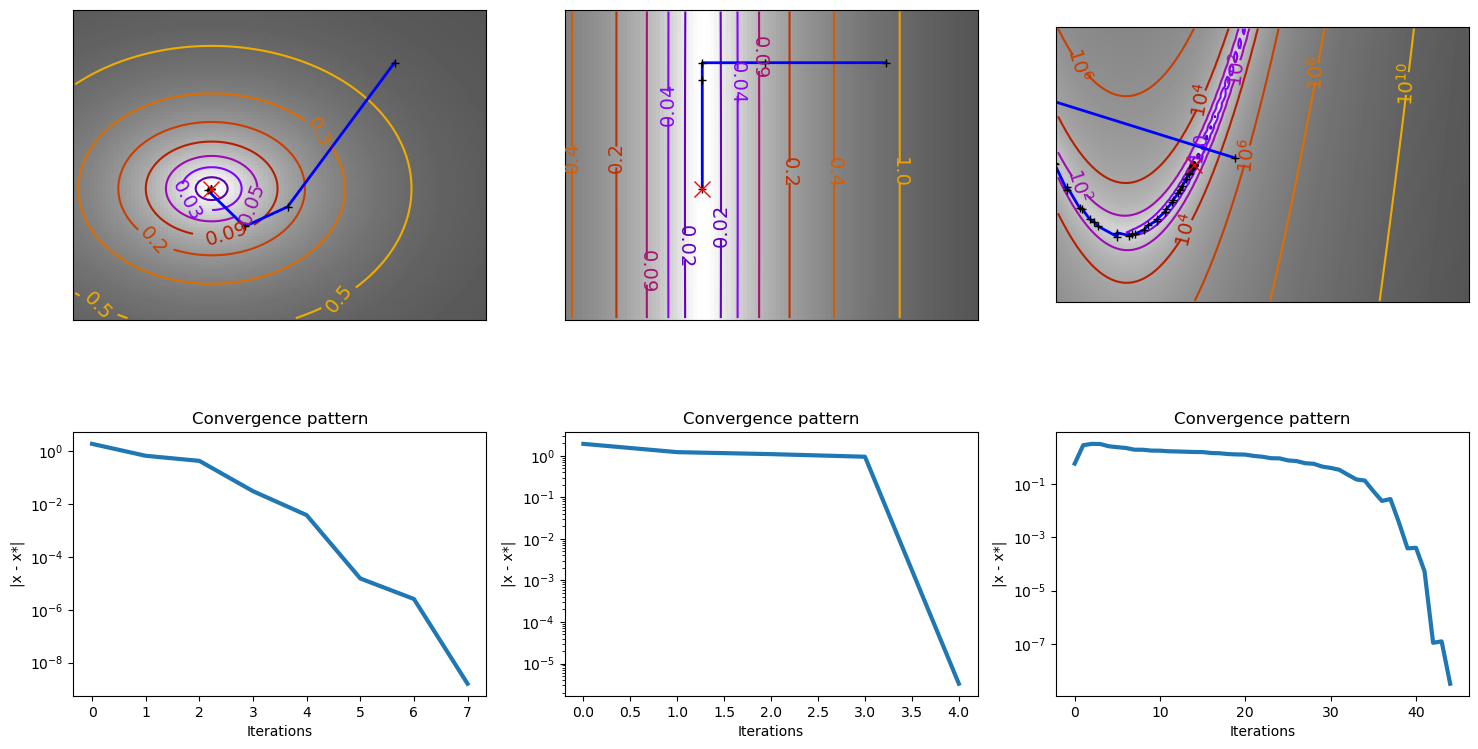

In [14]:
test_solver(lbfgs)


<div class="alert alert-info">

- LBFGS is a variation of BFGS that uses less memory because it does not store the full Hessian matrix.
- In this case, there is no memory issue since $p=2$, so LBFGS performs similarly to BFGS and requires a similar number of iterations to converge.
- We may get different results if we work in a higher-dimensional space.
    
</div>
